UNI-ID:  SVW2112

**Shapley value feature selection with a random forest classifier**

Import libraries



In [ ]:
# Needed in Google Colab
!pip install shap

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import shap

import matplotlib.pyplot as plt
from copy import deepcopy

Load the dataset and show some example images.

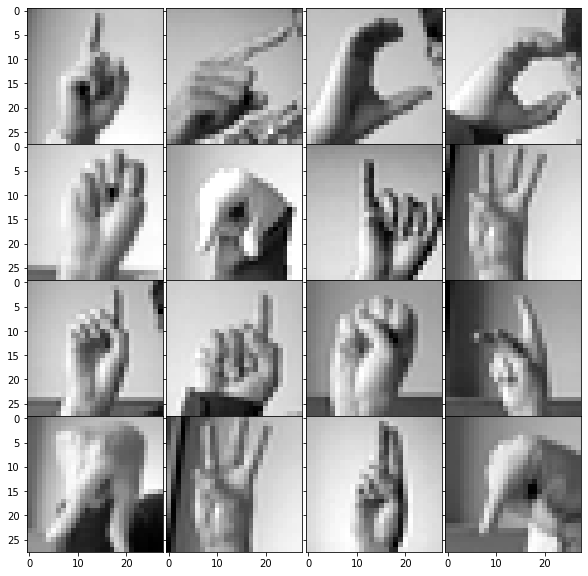

In [17]:
def load_data():
  train = pd.read_csv('train.csv')
  test = pd.read_csv('test.csv')

  train_labels = train['label'].values
  test_labels = test['label'].values

  train.drop('label', axis=1, inplace=True)
  test.drop('label', axis=1, inplace=True)

  num_classes = test_labels.max() + 1
  train_images = train.values / 255.0
  test_images = test.values / 255.0
  return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_data()
nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(nrows):
    for j in range(ncols):
        axs[i][j].imshow(train_images[i*ncols+j].reshape(28, 28), cmap='gray')
plt.show()

First-level Shapley analysis using the Python SHAP package and taking all 784 pixels as individual features. The plot obtained shows that some pixels contribute more to classifier accuracy than others.

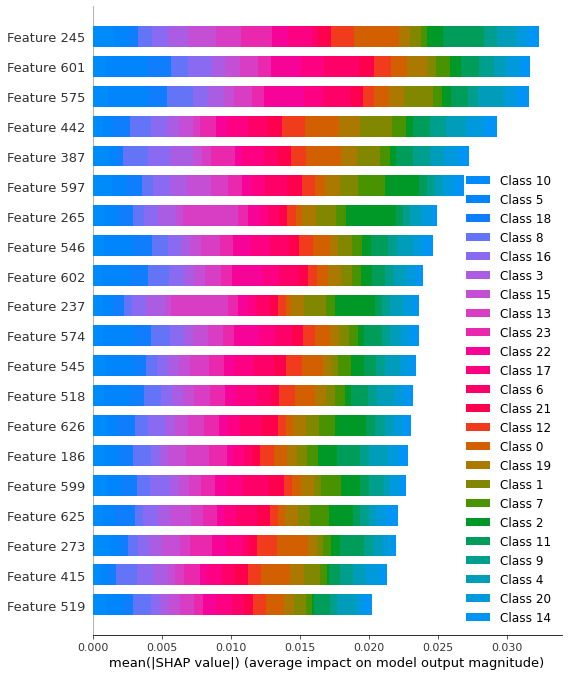

In [10]:
train_images, train_labels, test_images, test_labels = load_data()
model = RandomForestClassifier()
model.fit(train_images, train_labels)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_images)
shap.summary_plot(shap_values, features=train_images)

The results above motivate exploring the relative contribution of different regions of the image. In the example that follows, we divide the images into four quadrants and consider the relative contributions of each quadrant (top-left, top-right, bottom-left, and bottom-right). The goal will be to see if some areas of the hand (roughly speaking) contribute more to communicating than others.

In [18]:
train_images, train_labels, test_images, test_labels = load_data()

Here is an example excluding the top-left group of pixels.

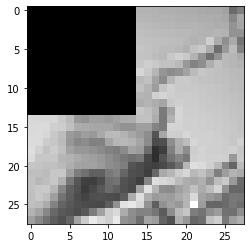

In [19]:
F = np.zeros((28, 28))
F[0:14, 0:14] = 1
F = F.flatten()
train_images[1, F == 1] = 0
plt.imshow(train_images[1,:].reshape(28, 28), cmap='gray')

Here is another example excluding the top-right and bottom-left pixel groups.

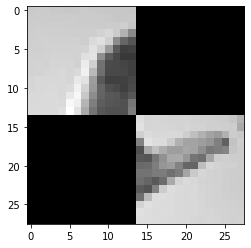

In [20]:
F = np.zeros((28, 28))
F[0:14, 14:28] = 1
F[14:28, 0:14] = 1
F = F.flatten()
train_images[2, F == 1] = 0
plt.imshow(train_images[2,:].reshape(28, 28), cmap='gray')

Run the classifier over all possible combinations of groups (excluding the one where all pixels are absent, which is assigned a baseline score of zero).
In this case there will be a total of 2^4 - 1 = 15 classifications to run.

In [25]:
nf = 4

def binary_coalition(q):
  x = []
  for p in range(nf):
    r = q % 2
    q = (q - r) / 2
    x.append(r == 1)
  x.reverse()
  return x

# Initialize with the null profile
T = [[False for p in range(nf)]]
acc = [0]

for k in range(1, 2**nf):
  # Load the data
  train_images, train_labels, test_images, test_labels = load_data()
  
  # Generate coalition
  x = binary_coalition(k)
  T.append(x)

  # Zero out the excluded features
  F = np.zeros((28, 28))
  F[0:14, 0:14] = 1 if not x[0] else 0
  F[0:14, 14:28] = 1 if not x[1] else 0
  F[14:28, 0:14] = 1 if not x[2] else 0
  F[14:28, 14:28] = 1 if not x[3] else 0
  F = F.flatten()

  # Obscure parts of the images
  train_images[:, F == 1] = 0
  test_images[:, F == 1] = 0

  # Train and get accuracy
  model = RandomForestClassifier()
  model.fit(train_images, train_labels)
  test_labels_pred = model.predict(test_images)
  acc.append(100 * np.sum(test_labels_pred == test_labels) / len(test_labels))

Compute and display the Shapley values (shown in the order of top-left, top-right, bottom-left, and bottom-right).

In [26]:
# Compute Shapley
def get_profile_index(x, T):
  for k in range(len(T)):
    if T[k] == x:
      return k
  return -1

S = []
for p in range(nf):
  # Track marginal accuracies by coalition size
  marginal_acc = [[], [], [], []]

  # Loop over all input profiles in the universe of the game
  # that do NOT containt player p
  for x in T:
    if not x[p]:
      # Find the size of the input profile
      n = np.sum(x)

      # Find base accuracy (without the player contributing)
      acc_base = acc[get_profile_index(x, T)]

      # Find the accuracy of the same coalition with the player now contributing
      v = deepcopy(x)
      v[p] = True
      acc_add = acc[get_profile_index(v, T)]

      # Add marginal accuracy
      marginal_acc[n].append(acc_add - acc_base)
  
  # Count coalition sizes
  #print(marginal_acc)
  V = 0
  for k in range(nf):
    V += np.mean(marginal_acc[k])
  V = V / nf
  S.append(V)

print(S)

[17.84021193530396, 24.71649005391337, 18.149284253578735, 19.22987544153188]


Here we see that the top right quandrant of the sign language images are more important than other quadrants in contributing to prediction accuracy.

A more interesting example might be to determine Shapley values for each finger of the hand, which would provide an estimate of how much information each finger communicates in sign language, relative to the other fingers. The main barrier to doing this is obtaining a good quality dataset: likely, a higher resolution than 28 x 28 pixels would be desirable, and it would also require labour intensive work of identifying and tracing the individual fingers of the hand in each training image. 

Access to full datasets and presentation video can be found at the following Google Drive location: 

https://drive.google.com/drive/folders/1pPR8L4Wl07o8QMf3xprcozO_XcGHfuWC?usp=sharing
